In [1]:
# importing packages
import numpy as np
import pandas as pd
from scipy import stats
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy import optimize
import time
import pickle

In [2]:
# active state deterministic fluorescence
def F_o(t,a,b_p,g,F_b,sd):
    
    b_m = 4.159
    
    p_0 = a/(b_p*b_m*g)
    
    if t < sd:
        
        p = F_b + p_0
        
    else:
        
        p = F_b + (a/(b_p*b_m) + a*(1-1/g)*np.exp(-b_m*(t-sd))/(b_m**2-b_p*b_m) + 
                   (p_0 - a/(b_p*b_m) - a*(1-1/g)/(b_m**2-b_p*b_m))*np.exp(-b_p*(t-sd)))
    
    return p

# silent state deterministic fluorescence
def F_s(t,t_l,a,b_p,g,F_b,sd):
    
    b_m = 4.159
    
    p_0 = a/(b_p*b_m*g)
    
    p_t_l = (a/(b_p*b_m) + a*(1-1/g)*np.exp(-b_m*(t_l-sd))/(b_m**2-b_p*b_m) + 
             (p_0 - a/(b_p*b_m) - a*(1-1/g)/(b_m**2-b_p*b_m))*np.exp(-b_p*(t_l-sd)))
    
    if t_l < sd:
        
        p = F_b + ((p_0-a/((b_p-b_m)*b_m*g))*np.exp(-b_p*(t-t_l)) + a*np.exp(-b_m*(t-t_l))/((b_p-b_m)*b_m*g))
    
    else:
        
        p = F_b + ((p_t_l + a*(1-(1-1/g)*np.exp(-b_m*(t_l-sd)))/(b_m**2-b_p*b_m))*np.exp(-b_p*(t-t_l)) -
             a*(1-(1-1/g)*np.exp(-b_m*(t_l-sd)))/(b_m**2-b_p*b_m)*np.exp(-b_m*(t-t_l)))
        
    return p

# probability density funciton
def f(x,t,alpha,beta,gamma,sigma,k,mu,P_b,P_aa,F_b,sd):
    
    always_active = P_aa*stats.norm.pdf(x,np.log10(F_o(t,alpha,beta,gamma,F_b,sd)))
    
    background = P_b*stats.norm.pdf(x,np.log10(F_b),sigma)
    
    on = (1-P_b-P_aa)*(1-stats.gamma.cdf(t,k,scale=mu/k))*stats.norm.pdf(x,np.log10(F_o(t,alpha,beta,gamma,F_b,sd)),sigma)
    
    n = np.size(x)
    
    if n == 1:
        f_s = integrate.quad(lambda t_lag: 
                             stats.norm.pdf(x,np.log10(F_s(t,t_lag,alpha,beta,gamma,F_b,sd)),sigma)\
                             *stats.gamma.pdf(t_lag,k,scale=mu/k),0,t)[0]
    else:
        f_s = np.zeros(n)
        for i in np.arange(n):
            f_s[i] = integrate.quad(lambda t_lag: 
                                    stats.norm.pdf(x[i],np.log10(F_s(t,t_lag,alpha,beta,gamma,F_b,sd)),sigma)\
                                    *stats.gamma.pdf(t_lag,k,scale=mu/k),0,t)[0]
    
    silent = (1-P_b-P_aa)*f_s
    
    F = always_active + on + background + silent
    
    return F

# general error function
def error(params,data_t,data_x,nbins=100):
    
    # timepoints
    t = np.unique(data_t)

    # initializing error array
    err = []

    # iterating through each timepoint to calculate error

    for i in np.arange(np.size(t)):
        # getting all data at time t[i]
        data_x_sub = data_x[data_t == t[i]]

        # bin data and convert to pdf
        actual_pdf,bins = np.histogram(data_x_sub,bins=nbins,density=True)

        # calculate bin width
        w = np.mean(bins[1:]-bins[:-1])

        # calculate bin midpoints
        bin_midpoints = bins[:-1]+w/2

        # evaluating model f(x,t) (PDF for fluorescence over time) at midpoints
        model_pdf = f(bin_midpoints,t[i],*params)

        # calculating and appending error
        err = np.append(err, actual_pdf - model_pdf)
        
    return err

def error_Cit(p_C,data_t,data_x,sd=0,nbins=100):
    
    # putting Cit params in overall params array, setting gamma and k to 1
    params = [p_C[0],p_C[1],1,p_C[2],1,p_C[3],p_C[4],p_C[5],p_C[6],sd]
        
    return error(params,data_t,data_x,nbins=nbins)

def error_mCh(p_m,data_t,data_x,beta,sd=0,nbins=100):
    
    # putting mCh params in overall params array, fixing beta
    params = [p_m[0],beta,p_m[1],p_m[2],p_m[3],p_m[4],p_m[5],P_aa,p_m[6],sd]
    
    return error(params,data_t,data_x,nbins=nbins)

def plotModelFit(cloneName, data_x, data_t, params, fluor, xlims, col=3):
    
    # setting color for fluorophore
    if fluor == 'Citrine':
        c = '#FFA900'
    elif fluor == 'mCherry':
        c = '#962A2F'
    else:
        c = 'gray'
    
    # timepoints
    t = np.unique(data_t)
    n = np.size(t)
    
    # creating figure
    rows = np.int(n/col) + (n%col>0)
    fig,ax = plt.subplots(rows,col,figsize=[12,6])

    # creating x vector
    x = np.linspace(xlims[0],xlims[1],100)

    # iterating through each timepoint and plotting data and model
    for i in np.arange(n):
        
        # calculating plot indicies
        k = np.int(i/col)
        j = np.int(i-k*col)
        
        # plotting model
        ax[k,j].plot(x,f(x,t[i],*params),lw=3)
        
        # plotting histogram of data
        data_x_sub = data_x[data_t == t[i]]
        ax[k,j].hist(data_x_sub,bins=100,range=xlims,density=True,color=c)
        
        # setting title as timepoint and removing tick labels
        ax[k,j].set_title('t = '+ np.str(t[i]),size='x-large')
        ax[k,j].set_xticklabels([])
        ax[k,j].set_yticklabels([])

    # formatting plot to axis labels don't overlap on plots
    plt.tight_layout()    

    # adding global title
    fig.suptitle(cloneName + ' Probabilistic Model Fit',size='xx-large')
    fig.subplots_adjust(top=0.88)

    # adding global xlabel
    fig.text(0.515,0,'Log ' + fluor + ' Fluorescence (AFU)',size='x-large',horizontalalignment='center')
    fig.subplots_adjust(bottom=0.05)

    # adding global ylabel
    fig.text(0,0.465,'Probability Denisty',size='x-large',rotation='vertical',verticalalignment='center')
    fig.subplots_adjust(left=0.03)
    
    # saving plot
    #plt.savefig(cloneName+'_'+fluor+'_ProbModelFit.png')
    
    # displaying plot
    plt.show()
    
def optProbModel(cloneNames,i_C,b_C,i_m,b_m,xlim_C=(2,5.5),xlim_m=(1.5,5.5),saveAs='cellLine'):
    
    # initializing dictionaries
    CitFits = {}
    mChFits = {}
    
    # iterating through each clone
    for cloneName in cloneNames:
        
        # loading the data for the clone
        data = pd.read_csv(cloneName+'.csv',header=None)
    
        # converting from data frame to array
        data = data.values
        data_t = data[:,2]
        data_C = data[:,0]
        data_m = data[:,1]
        
        # optimizing Citrine parameters
        p = optimize.least_squares(error_Cit, i_C, bounds=b_C, args=(data_t,data_C))
        params = [p.x[0],p.x[1],1,p.x[2],1,p.x[3],p.x[4],p.x[5],p.x[6],0]
        print(params)
        
        # plotting model versus data for Citrine
        plotModelFit(cloneName,data_C,data_t,params,fluor='Citrine',xlims=xlim_C)
        
        # saving params in Citrine dict
        CitFits[cloneName] = params
        beta = params[1]
        sd = params[5]
        P_aa = params[7]
        
        # optimizing mCherry parameters
        p = optimize.least_squares(error_mCh, i_m, bounds=b_m, args=(data_t,data_m,beta,sd))
        params = [p.x[0],beta,p.x[1],p.x[2],p.x[3],p.x[4],p.x[5],P_aa,p.x[6],sd]
        print(params)
        
        # plotting model versus data for Citrine
        plotModelFit(cloneName,data_m,data_t,params,fluor='mCherry',xlims=xlim_m)
        
        # saving params in mCherry dict
        mChFits[cloneName] = params
        
    # saving the dictionaries
    with open(saveAs + '.pkl', 'wb') as f:
        pickle.dump((CitFits, mChFits), f)

### CHO HDAC4 1.2kb lambda low dox 

In [35]:
# setting inital guesses and bounds for Citrine
alpha = 45000  
beta = 0.8        
sigma = 0.15           
mu = 4/24      
P_b = 0.05
P_aa = 0.25
F_b = 560     

i_C = [alpha,beta,sigma,mu,P_b,P_aa,F_b]

b_C = ([10000,  0.5, 0.1, 0.001, 0,   0.1,  100],\
       [1000000, 2.0, 0.4, 3,   0.25, 0.5, 1000])

# setting inital guesses and bounds for mCherry
alpha = 25000      
gamma = 3  
sigma = 0.30   
k = 5          
mu = 2.5       
P_b = 0.40     
F_b = 630      

i_m = [alpha,gamma,sigma,k,mu,P_b,F_b]

b_m = ([5000,   1,  0.1, 1,  0, 0,    100],\
       [100000, 15, 0.4, 15, 5, 0.60, 1000])

[47044.27975992193, 0.93318755448065, 1, 0.1728025089742385, 1, 2.575028694374438, 0.13999838305671106, 0.1908681262953368, 219.03115655379415, 0]


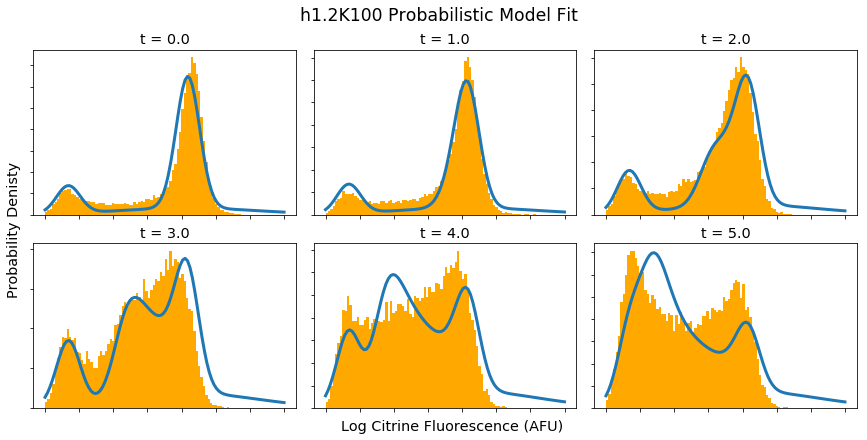

[14431.28682138193, 0.93318755448065, 4.13761504872723, 0.1786687172639862, 14.999999999999998, 3.6459754666556003, 0.5183722356276782, 0.1908681262953368, 204.81046030018996, 2.575028694374438]


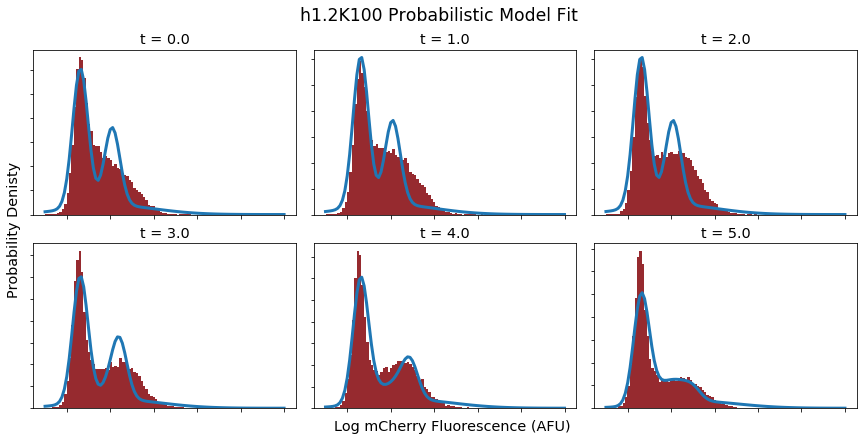

5911.569430112839


In [36]:
start = time.time()

cloneNames = ['h1.2K100']

optProbModel(cloneNames,i_C,b_C,i_m,b_m,xlim_C=(2,5.5),xlim_m=(1.5,7),saveAs='CHO_HDAC4_1.2kb_100dox_fit')

end = time.time()
print(end-start)

In [41]:
# setting inital guesses and bounds for Citrine
alpha = 45000  
beta = 0.8        
sigma = 0.15           
mu = 4/24      
P_b = 0.05
P_aa = 0.25
F_b = 560     

i_C = [alpha,beta,sigma,mu,P_b,P_aa,F_b]

b_C = ([10000,  0.5, 0.1, 0.001, 0,   0.1,  100],\
       [1000000, 2.0, 0.4, 3,   0.25, 0.5, 1000])

# setting inital guesses and bounds for mCherry (Changed  mch silencing time upper bound)
alpha = 25000      
gamma = 3  
sigma = 0.30   
k = 5          
mu = 2.5       
P_b = 0.40     
F_b = 630      

i_m = [alpha,gamma,sigma,k,mu,P_b,F_b]

b_m = ([5000,   1,  0.1, 1,  0, 0,    100],\
       [100000, 15, 0.4, 15, 8, 0.60, 1000])

[47044.27975992193, 0.93318755448065, 1, 0.1728025089742385, 1, 2.575028694374438, 0.13999838305671106, 0.1908681262953368, 219.03115655379415, 0]


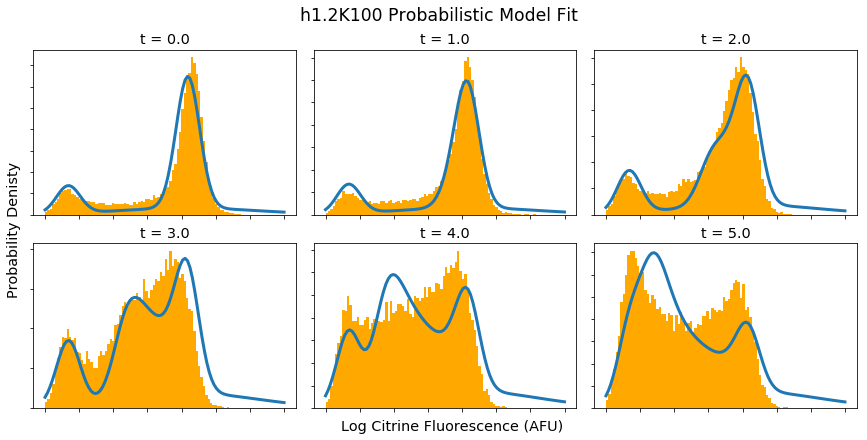

[14431.608752489965, 0.93318755448065, 4.13783955075159, 0.17866787515950236, 14.999999999999998, 3.645951381414656, 0.5183710514064025, 0.1908681262953368, 204.81014551901902, 2.575028694374438]


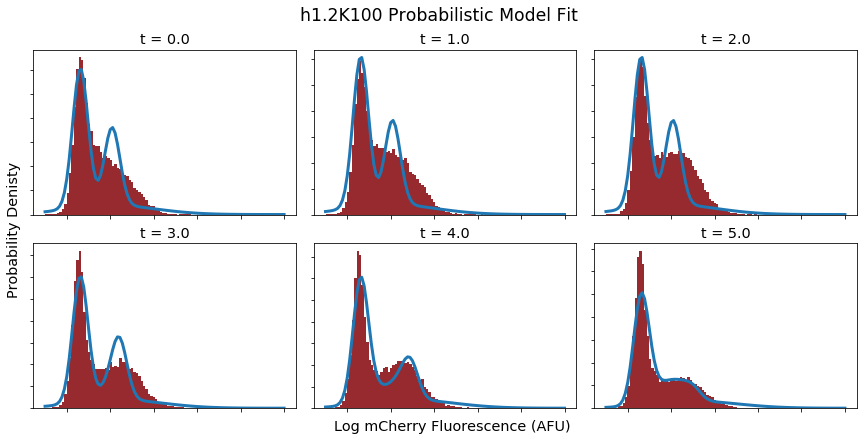

7637.138137340546


In [42]:
start = time.time()

cloneNames = ['h1.2K100']

optProbModel(cloneNames,i_C,b_C,i_m,b_m,xlim_C=(2,5.5),xlim_m=(1.5,7),saveAs='CHO_HDAC4_1.2kb_100dox_fit')

end = time.time()
print(end-start)

In [6]:
# setting inital guesses and bounds for Citrine
alpha = 45000  
beta = 0.8        
sigma = 0.15           
mu = 4/24      
P_b = 0.05   
P_aa = 0.25
F_b = 560     

i_C = [alpha,beta,sigma,mu,P_b,P_aa,F_b]

b_C = ([10000,  0.5, 0.1, 0.001, 0,   0.1,  100],\
       [1000000, 2.0, 0.4, 3,   0.25, 0.5, 1000])

# setting inital guesses and bounds for mCherry
alpha = 25000      
gamma = 3  
sigma = 0.30   
k = 5          
mu = 2.5       
P_b = 0.40     
F_b = 630      

i_m = [alpha,gamma,sigma,k,mu,P_b,F_b]

b_m = ([5000,   1,  0.2, 1,  0, 0,    100],\
       [100000, 15, 0.4, 15, 5, 0.60, 1000])

[50393.27166967032, 0.9789322096837301, 1, 0.17598869687127475, 1, 1.574029148524221, 0.14495738615581322, 0.1690847686841738, 214.61255766225605, 0]


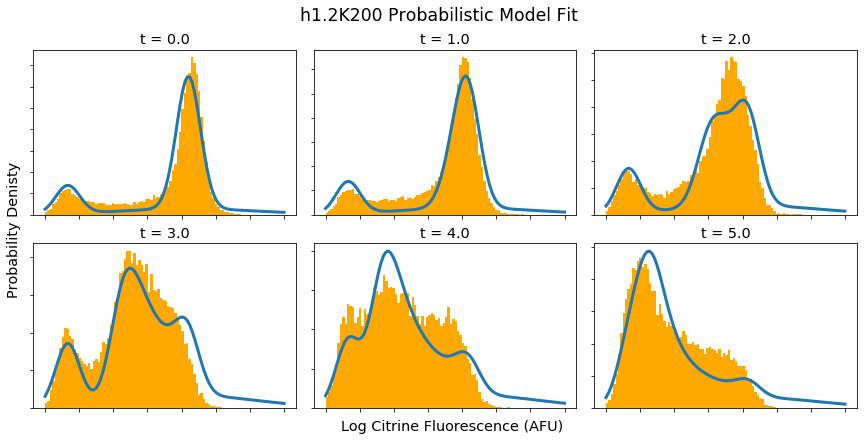

[12801.726226788505, 0.9789322096837301, 3.319315678572076, 0.20000000000000004, 6.0474143776805, 3.6987645493486583, 0.5148306407486155, 0.1690847686841738, 206.21785231257326, 1.574029148524221]


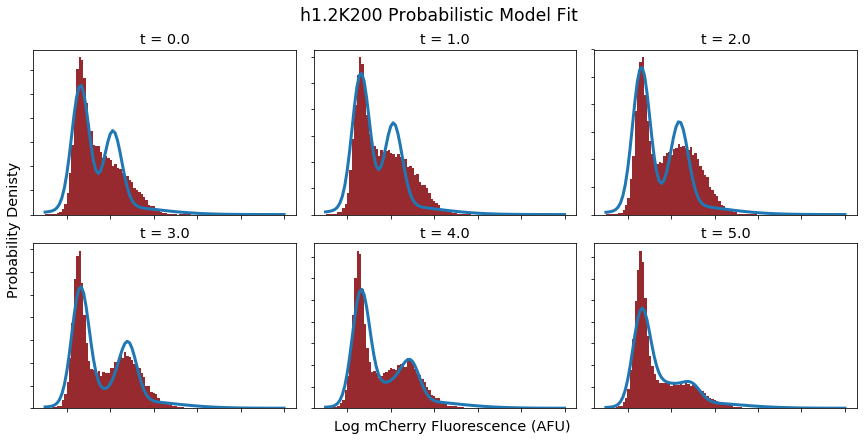

4786.196984052658


In [7]:
start = time.time()

cloneNames = ['h1.2K200']

optProbModel(cloneNames,i_C,b_C,i_m,b_m,xlim_C=(2,5.5),xlim_m=(1.5,7),saveAs='CHO_HDAC4_1.2kb_200dox_fit')

end = time.time()
print(end-start)

In [8]:
# setting inital guesses and bounds for Citrine
alpha = 45000  
beta = 0.8        
sigma = 0.15           
mu = 4/24      
P_b = 0.05
P_aa = 0.25
F_b = 560     

i_C = [alpha,beta,sigma,mu,P_b,P_aa,F_b]

b_C = ([10000,  0.5, 0.1, 0.001, 0,   0.1,  100],\
       [1000000, 2.0, 0.4, 3,   0.25, 0.5, 1000])

# setting inital guesses and bounds for mCherry
alpha = 25000      
gamma = 3  
sigma = 0.30   
k = 5          
mu = 2.5       
P_b = 0.40     
F_b = 630      

i_m = [alpha,gamma,sigma,k,mu,P_b,F_b]

b_m = ([5000,   1,  0.1, 1,  0, 0,    100],\
       [100000, 15, 0.4, 15, 5, 0.60, 1000])

[56951.884127651865, 1.009597243842201, 1, 0.1746048447058618, 1, 0.5613741935007317, 0.16360358982159956, 0.11200394389317547, 210.3146301183965, 0]


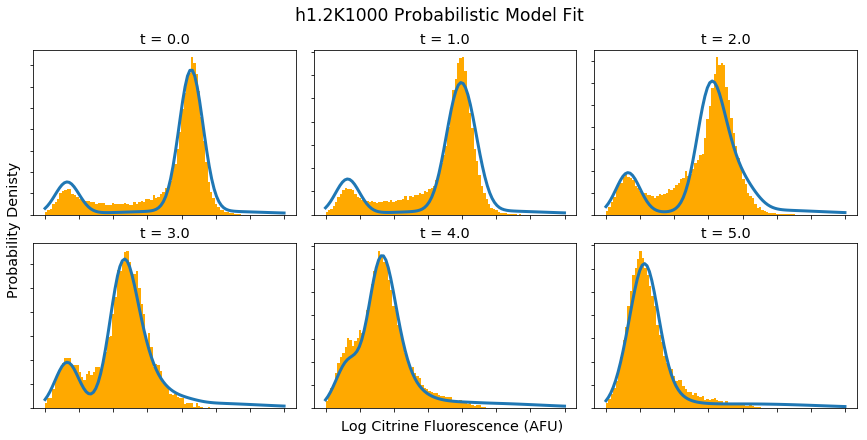

[15542.456883679995, 1.009597243842201, 7.204128822302775, 0.1679460634829007, 2.153582975943098, 2.3591958794322676, 0.4481214283621027, 0.11200394389317547, 193.2097494517475, 0.5613741935007317]


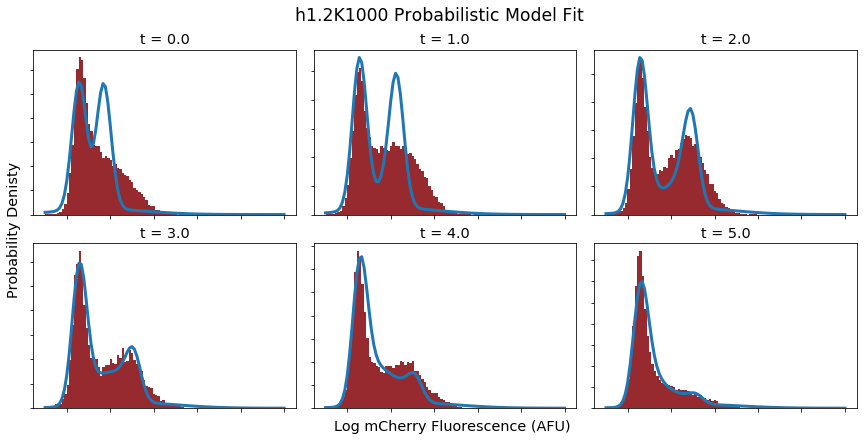

16119.790399312973


In [9]:
start = time.time()

cloneNames = ['h1.2K1000']

optProbModel(cloneNames,i_C,b_C,i_m,b_m,xlim_C=(2,5.5),xlim_m=(1.5,7),saveAs='CHO_HDAC4_1.2kb_1000dox_fit')

end = time.time()
print(end-start)

### CHO HDAC4 Ins (MC) SC low dox

In [10]:
# setting inital guesses and bounds for Citrine
alpha = 45000  
beta = 0.8        
sigma = 0.15           
mu = 4/24      
P_b = 0.05
P_aa = 0.25
F_b = 560     

i_C = [alpha,beta,sigma,mu,P_b,P_aa,F_b]

b_C = ([10000,  0.5, 0.1, 0.001, 0,   0.1,  100],\
       [1000000, 2.0, 0.4, 3,   0.25, 0.5, 1000])

# setting inital guesses and bounds for mCherry
alpha = 25000      
gamma = 3  
sigma = 0.30   
k = 5          
mu = 2.5       
P_b = 0.40     
F_b = 630      

i_m = [alpha,gamma,sigma,k,mu,P_b,F_b]

b_m = ([5000,   1,  0.1, 1,  0, 0,    100],\
       [100000, 15, 0.4, 15, 5, 0.60, 1000])

[62456.69657326955, 1.0092647053366843, 1, 0.15148526582565258, 1, 2.3333977001758, 0.13908734277427404, 0.1287937350358017, 193.93635913139232, 0]


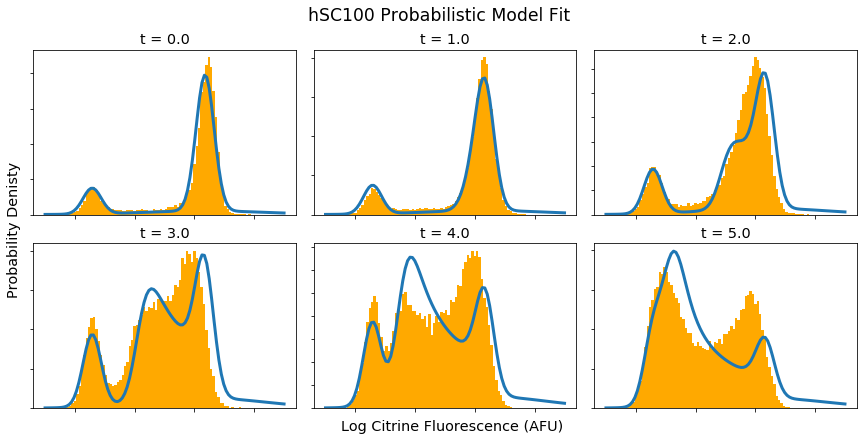

[19367.138853943216, 1.0092647053366843, 1.0636949221202994, 0.28184326555051376, 1.0070816612964404, 4.999999999999999, 0.20914693004129975, 0.1287937350358017, 273.28772519146503, 2.3333977001758]


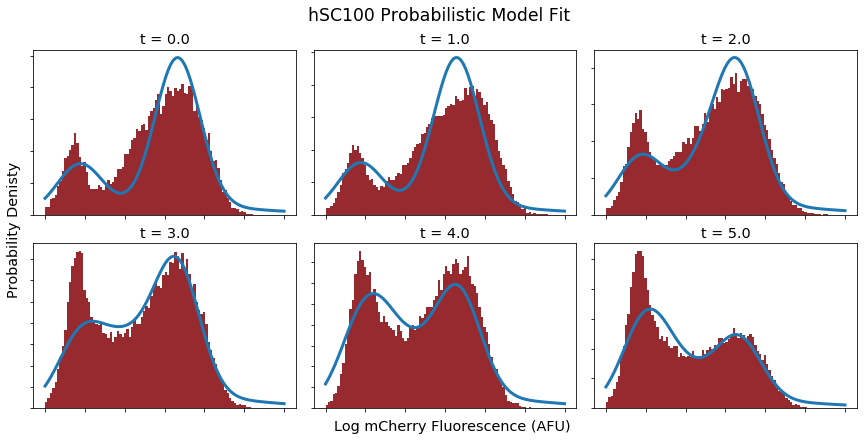

8145.058168172836


In [11]:
start = time.time()

cloneNames = ['hSC100']

optProbModel(cloneNames,i_C,b_C,i_m,b_m,xlim_C=(1.5,5.5),xlim_m=(2,5),saveAs='CHO_HSC_100dox_fit')

end = time.time()
print(end-start)

In [43]:
# setting inital guesses and bounds for Citrine
alpha = 45000  
beta = 0.8        
sigma = 0.15           
mu = 4/24      
P_b = 0.05
P_aa = 0.25
F_b = 560     

i_C = [alpha,beta,sigma,mu,P_b,P_aa,F_b]

b_C = ([10000,  0.5, 0.1, 0.001, 0,   0.1,  100],\
       [1000000, 2.0, 0.4, 3,   0.25, 0.5, 1000])

# setting inital guesses and bounds for mCherry (Changed  mch silencing time upper bound)
alpha = 25000      
gamma = 3  
sigma = 0.30   
k = 5          
mu = 2.5       
P_b = 0.40     
F_b = 630      

i_m = [alpha,gamma,sigma,k,mu,P_b,F_b]

b_m = ([5000,   1,  0.1, 1,  0, 0,    100],\
       [100000, 15, 0.4, 15, 8, 0.60, 1000])

[62456.69657326955, 1.0092647053366843, 1, 0.15148526582565258, 1, 2.3333977001758, 0.13908734277427404, 0.1287937350358017, 193.93635913139232, 0]


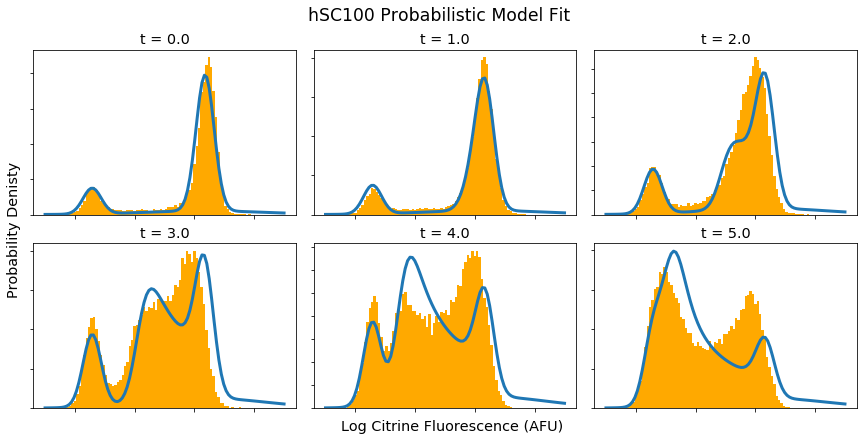

[18562.121478493824, 1.0092647053366843, 1.0321422134111613, 0.28309844211178103, 1.0000000000000002, 5.929323385804906, 0.21739125677426108, 0.1287937350358017, 279.24365941827745, 2.3333977001758]


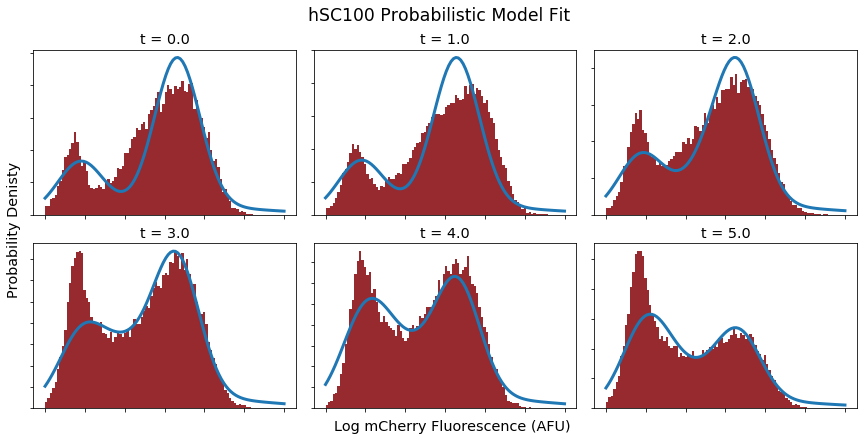

5266.035142660141


In [44]:
start = time.time()

cloneNames = ['hSC100']

optProbModel(cloneNames,i_C,b_C,i_m,b_m,xlim_C=(1.5,5.5),xlim_m=(2,5),saveAs='CHO_HSC_100dox_fit')

end = time.time()
print(end-start)

In [12]:
# setting inital guesses and bounds for Citrine
alpha = 45000  
beta = 0.8        
sigma = 0.15           
mu = 4/24      
P_b = 0.05
P_aa = 0.25
F_b = 560     

i_C = [alpha,beta,sigma,mu,P_b,P_aa,F_b]

b_C = ([10000,  0.5, 0.1, 0.001, 0,   0.1,  100],\
       [1000000, 2.0, 0.4, 3,   0.25, 0.5, 1000])

# setting inital guesses and bounds for mCherry
alpha = 25000      
gamma = 3  
sigma = 0.30   
k = 5          
mu = 2.5       
P_b = 0.40     
F_b = 630      

i_m = [alpha,gamma,sigma,k,mu,P_b,F_b]

b_m = ([5000,   1,  0.1, 1,  0, 0,    100],\
       [100000, 15, 0.4, 15, 5, 0.60, 1000])

[57380.63157787898, 0.9147052220593058, 1, 0.1536821879011133, 1, 1.1888677235471785, 0.1470507617667842, 0.15258832619173007, 203.31180523448785, 0]


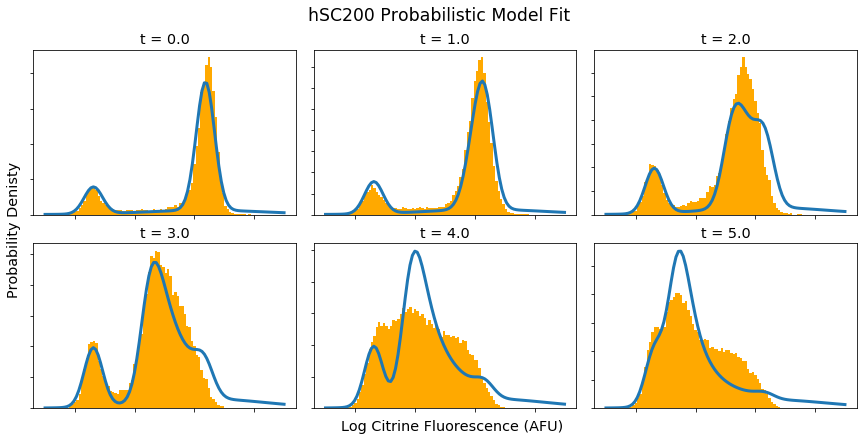

[16453.003276557592, 0.9147052220593058, 1.0000000093301833, 0.27790166685746304, 1.0000000000000002, 3.4600306563736516, 0.2377458934029667, 0.15258832619173007, 266.6964277397365, 1.1888677235471785]


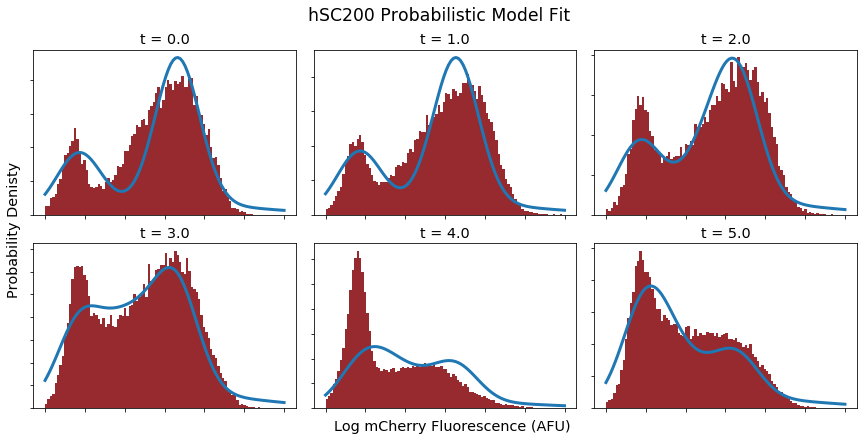

4807.552225589752


In [13]:
start = time.time()

cloneNames = ['hSC200']

optProbModel(cloneNames,i_C,b_C,i_m,b_m,xlim_C=(1.5,5.5),xlim_m=(2,5),saveAs='CHO_HSC_200dox_fit')

end = time.time()
print(end-start)

In [14]:
# setting inital guesses and bounds for Citrine
alpha = 45000  
beta = 0.8        
sigma = 0.15           
mu = 4/24      
P_b = 0.05
P_aa = 0.25
F_b = 560     

i_C = [alpha,beta,sigma,mu,P_b,P_aa,F_b]

b_C = ([10000,  0.5, 0.1, 0.001, 0,   0.1,  100],\
       [1000000, 2.0, 0.4, 3,   0.25, 0.5, 1000])

# setting inital guesses and bounds for mCherry
alpha = 25000      
gamma = 3  
sigma = 0.30   
k = 5          
mu = 2.5       
P_b = 0.40     
F_b = 630      

i_m = [alpha,gamma,sigma,k,mu,P_b,F_b]

b_m = ([5000,   1,  0.1, 1,  0, 0,    100],\
       [100000, 15, 0.4, 15, 5, 0.60, 1000])

[65419.619236716855, 0.9955571531360623, 1, 0.15918861947558968, 1, 0.40016064112687655, 0.16023643162796625, 0.10450476664218873, 197.6944666624143, 0]


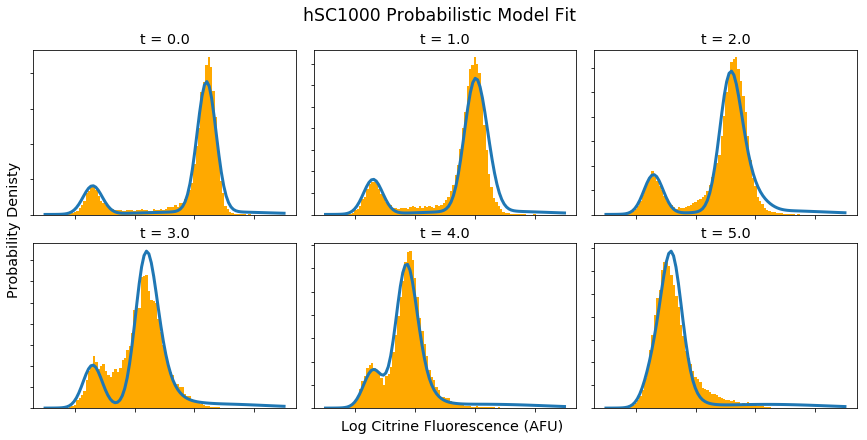

[24484.046856743767, 0.9955571531360623, 1.4889949979138184, 0.22210495954599424, 1.093068889751764, 1.5773057193418398, 0.2647411424726284, 0.10450476664218873, 240.3555504131529, 0.40016064112687655]


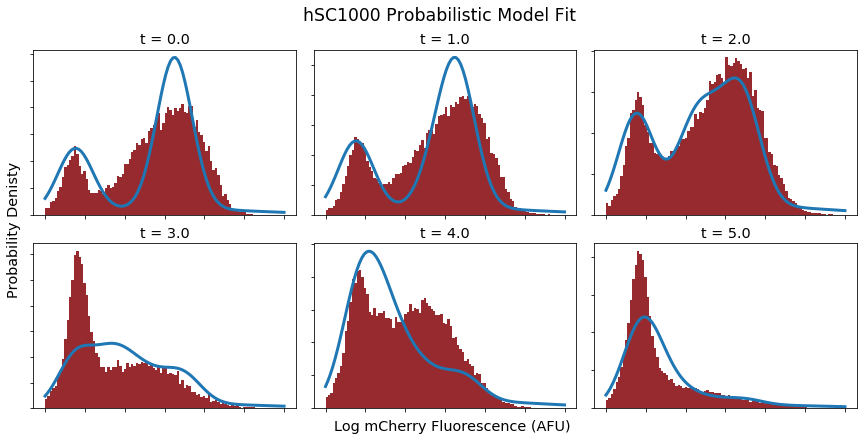

11770.166643619537


In [15]:
start = time.time()

cloneNames = ['hSC1000']

optProbModel(cloneNames,i_C,b_C,i_m,b_m,xlim_C=(1.5,5.5),xlim_m=(2,5),saveAs='CHO_HSC_1000dox_fit')

end = time.time()
print(end-start)

### CHO HDAC4 Ins (MC) SH low dox

In [16]:
# setting inital guesses and bounds for Citrine
alpha = 45000  
beta = 0.8        
sigma = 0.15           
mu = 4/24      
P_b = 0.05
P_aa = 0.25
F_b = 560     

i_C = [alpha,beta,sigma,mu,P_b,P_aa,F_b]

b_C = ([10000,  0.5, 0.1, 0.001, 0,   0.1,  100],\
       [1000000, 2.0, 0.4, 3,   0.25, 0.5, 1000])

# setting inital guesses and bounds for mCherry
alpha = 25000      
gamma = 3  
sigma = 0.30   
k = 5          
mu = 2.5       
P_b = 0.40     
F_b = 630      

i_m = [alpha,gamma,sigma,k,mu,P_b,F_b]

b_m = ([5000,   1,  0.1, 1,  0, 0,    100],\
       [100000, 15, 0.4, 15, 5, 0.60, 1000])

[34435.36808807666, 0.5000000000013983, 1, 0.1460613372133861, 1, 2.927394975369506, 0.045358411664697056, 0.1084378682744169, 220.3702409655316, 0]


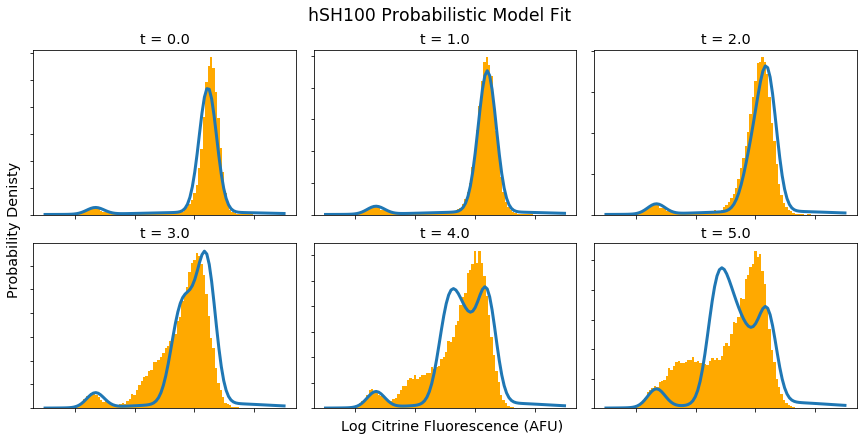

[20254.411291555276, 0.5000000000013983, 1.000000001057696, 0.3342998484569895, 1.4530417024763527, 4.999999999999999, 0.24030896414131367, 0.1084378682744169, 496.7396868452366, 2.927394975369506]


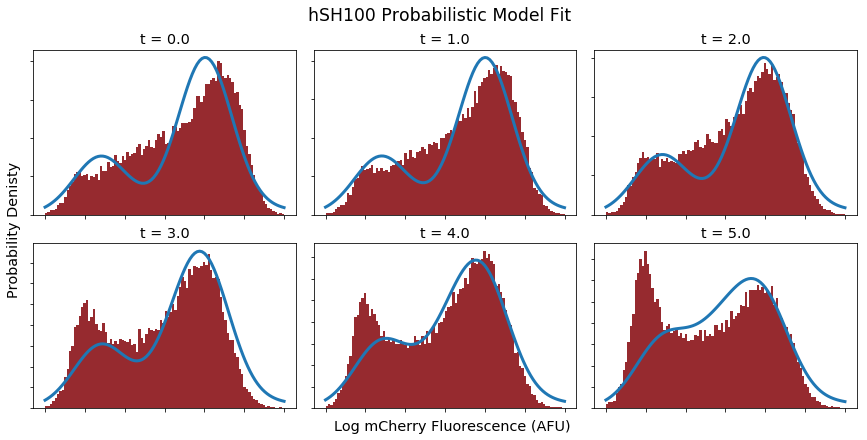

5655.172930240631


In [17]:
start = time.time()

cloneNames = ['hSH100']

optProbModel(cloneNames,i_C,b_C,i_m,b_m,xlim_C=(1.5,5.5),xlim_m=(2,5),saveAs='CHO_HSH_100dox_fit')

end = time.time()
print(end-start)

In [45]:
# setting inital guesses and bounds for Citrine
alpha = 45000  
beta = 0.8        
sigma = 0.15           
mu = 4/24      
P_b = 0.05
P_aa = 0.25
F_b = 560     

i_C = [alpha,beta,sigma,mu,P_b,P_aa,F_b]

b_C = ([10000,  0.5, 0.1, 0.001, 0,   0.1,  100],\
       [1000000, 2.0, 0.4, 3,   0.25, 0.5, 1000])

# setting inital guesses and bounds for mCherry (Changed  mch silencing time upper bound)
alpha = 25000      
gamma = 3  
sigma = 0.30   
k = 5          
mu = 2.5       
P_b = 0.40     
F_b = 630      

i_m = [alpha,gamma,sigma,k,mu,P_b,F_b]

b_m = ([5000,   1,  0.1, 1,  0, 0,    100],\
       [100000, 15, 0.4, 15, 8, 0.60, 1000])

[34435.36808807666, 0.5000000000013983, 1, 0.1460613372133861, 1, 2.927394975369506, 0.045358411664697056, 0.1084378682744169, 220.3702409655316, 0]


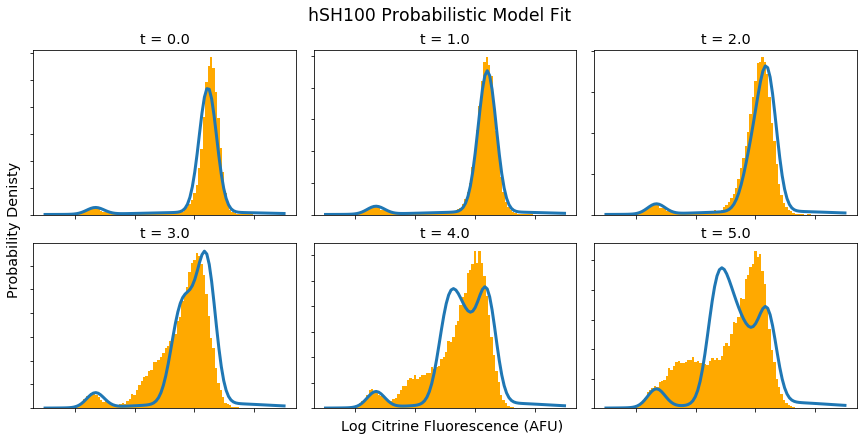

[19947.330565684802, 0.5000000000013983, 1.0000000000000002, 0.334168828603975, 1.0000000000009182, 7.2482955082135465, 0.23877517856170566, 0.1084378682744169, 495.6998372353637, 2.927394975369506]


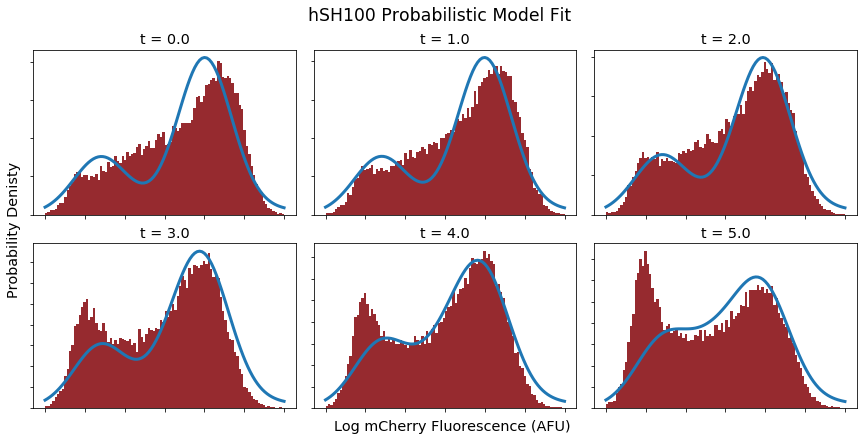

4720.406048774719


In [46]:
start = time.time()

cloneNames = ['hSH100']

optProbModel(cloneNames,i_C,b_C,i_m,b_m,xlim_C=(1.5,5.5),xlim_m=(2,5),saveAs='CHO_HSH_100dox_fit')

end = time.time()
print(end-start)

In [18]:
# setting inital guesses and bounds for Citrine
alpha = 45000  
beta = 0.8        
sigma = 0.15           
mu = 4/24      
P_b = 0.05
P_aa = 0.25
F_b = 560     

i_C = [alpha,beta,sigma,mu,P_b,P_aa,F_b]

b_C = ([10000,  0.5, 0.1, 0.001, 0,   0.1,  100],\
       [1000000, 2.0, 0.4, 3,   0.25, 0.5, 1000])

# setting inital guesses and bounds for mCherry
alpha = 25000      
gamma = 3  
sigma = 0.30   
k = 5          
mu = 2.5       
P_b = 0.40     
F_b = 630      

i_m = [alpha,gamma,sigma,k,mu,P_b,F_b]

b_m = ([5000,   1,  0.1, 1,  0, 0,    100],\
       [100000, 15, 0.4, 15, 5, 0.60, 1000])

[49729.08288121866, 0.713519537540902, 1, 0.15030548192104046, 1, 1.5734682507869144, 0.008190133058697221, 0.12798002525566254, 100.00000000000001, 0]


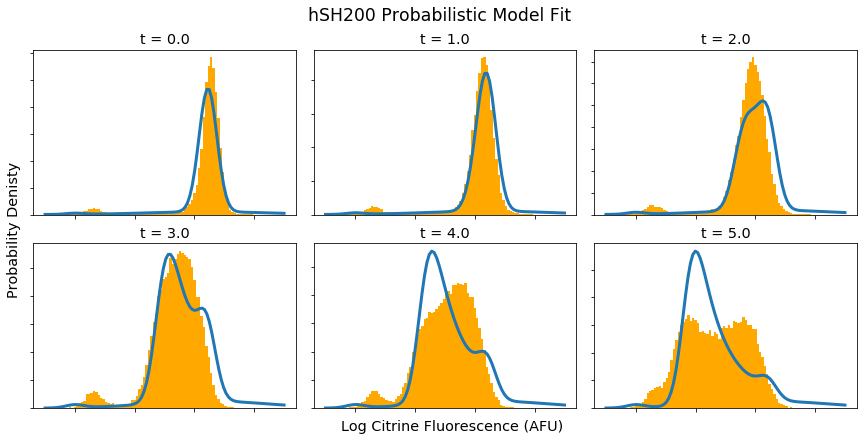

[27042.528147175428, 0.713519537540902, 1.0000000000000002, 0.3396206214693113, 1.365351888882693, 4.349002500014521, 0.21124074347729704, 0.12798002525566254, 452.60775106082207, 1.5734682507869144]


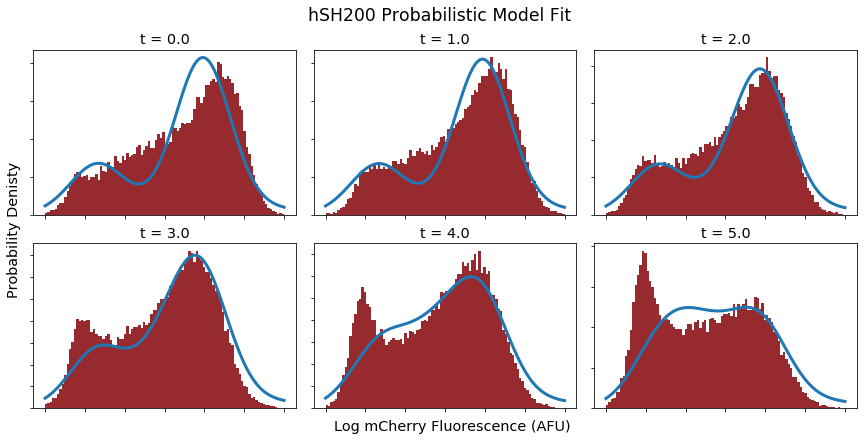

4940.074398756027


In [19]:
start = time.time()

cloneNames = ['hSH200']

optProbModel(cloneNames,i_C,b_C,i_m,b_m,xlim_C=(1.5,5.5),xlim_m=(2,5),saveAs='CHO_HSH_200dox_fit')

end = time.time()
print(end-start)

In [20]:
# setting inital guesses and bounds for Citrine
alpha = 45000  
beta = 0.8        
sigma = 0.15           
mu = 4/24      
P_b = 0.05
P_aa = 0.25
F_b = 560     

i_C = [alpha,beta,sigma,mu,P_b,P_aa,F_b]

b_C = ([10000,  0.5, 0.1, 0.001, 0,   0.1,  100],\
       [1000000, 2.0, 0.4, 3,   0.25, 0.5, 1000])

# setting inital guesses and bounds for mCherry
alpha = 25000      
gamma = 3  
sigma = 0.30   
k = 5          
mu = 2.5       
P_b = 0.40     
F_b = 630      

i_m = [alpha,gamma,sigma,k,mu,P_b,F_b]

b_m = ([5000,   1,  0.1, 1,  0, 0,    100],\
       [100000, 15, 0.4, 15, 5, 0.60, 1000])

[67291.27655263229, 0.8955335819225396, 1, 0.13882194871520273, 1, 0.4431585662554507, 0.038973104625684284, 0.10000000000000002, 205.70433736652038, 0]


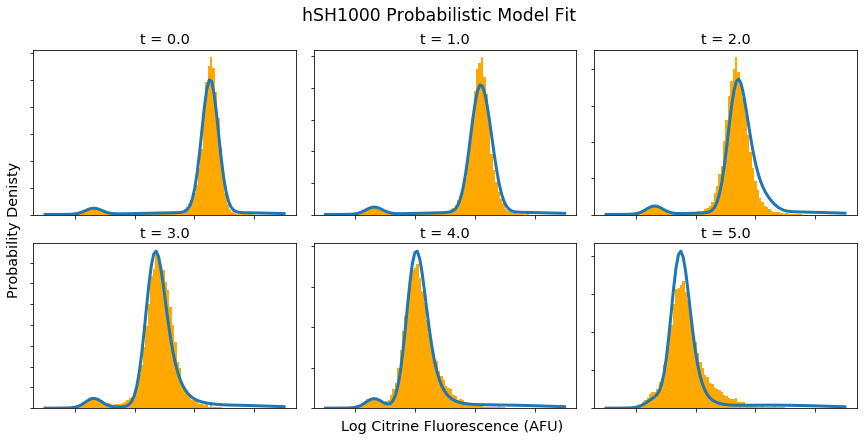

[34226.540922983004, 0.8955335819225396, 1.0000000000000002, 0.3442512833520642, 1.7576680268026958, 1.8511985448747241, 0.2097487359364058, 0.10000000000000002, 352.457050695008, 0.4431585662554507]


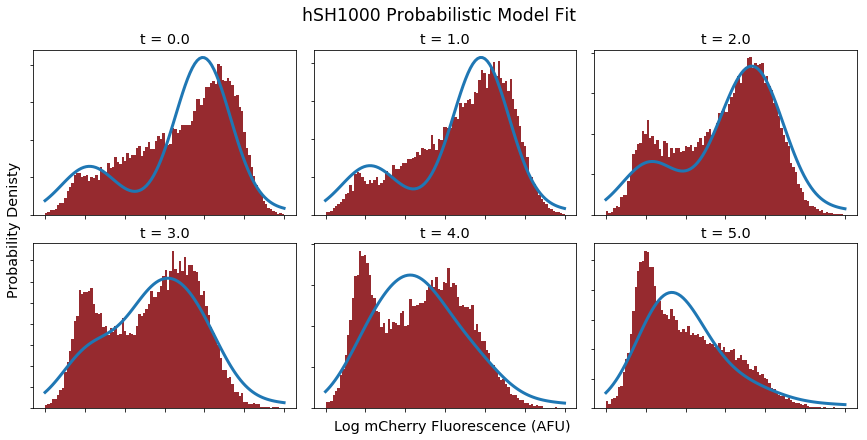

4081.5847132205963


In [21]:
start = time.time()

cloneNames = ['hSH1000']

optProbModel(cloneNames,i_C,b_C,i_m,b_m,xlim_C=(1.5,5.5),xlim_m=(2,5),saveAs='CHO_HSH_1000dox_fit')

end = time.time()
print(end-start)

### CHO HDAC4 Ins (MC) DC low dox

In [22]:
# setting inital guesses and bounds for Citrine
alpha = 45000  
beta = 0.8        
sigma = 0.15           
mu = 4/24      
P_b = 0.05
P_aa = 0.25
F_b = 560     

i_C = [alpha,beta,sigma,mu,P_b,P_aa,F_b]

b_C = ([10000,  0.5, 0.1, 0.001, 0,   0.1,  100],\
       [1000000, 2.0, 0.4, 3,   0.25, 0.5, 1000])

# setting inital guesses and bounds for mCherry
alpha = 25000      
gamma = 3  
sigma = 0.30   
k = 5          
mu = 2.5       
P_b = 0.40     
F_b = 630      

i_m = [alpha,gamma,sigma,k,mu,P_b,F_b]

b_m = ([5000,   1,  0.1, 1,  0, 0,    100],\
       [100000, 15, 0.4, 15, 5, 0.60, 1000])

[48494.67507035388, 0.7245527586775352, 1, 0.19453737473043684, 1, 2.197847940990429, 0.08134968635677063, 0.10000000000000002, 217.29948186220037, 0]


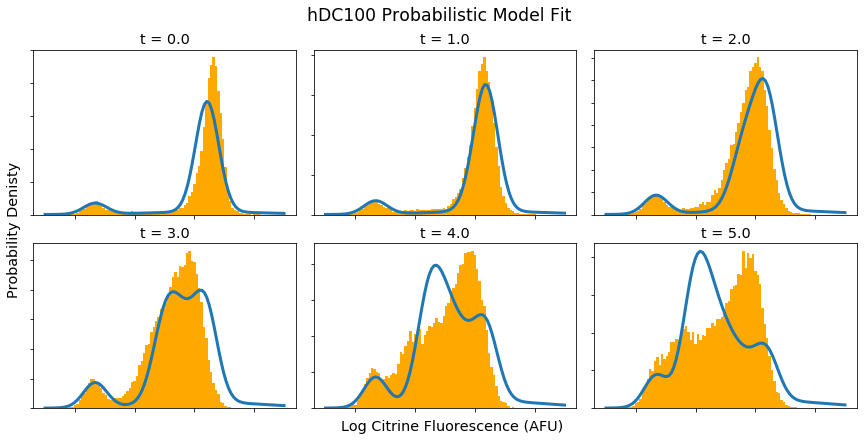

[15360.414245061536, 0.7245527586775352, 1.7901076256532815, 0.2978285247164425, 1.0000000000000733, 4.99999999936824, 0.17574684140996938, 0.10000000000000002, 353.246849572963, 2.197847940990429]


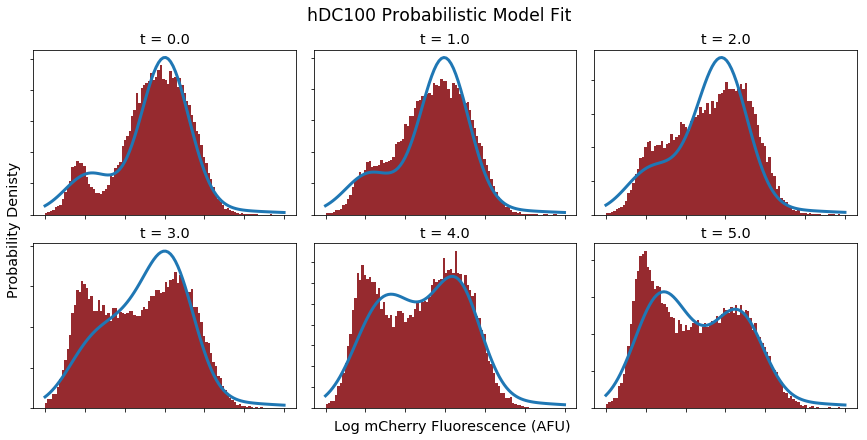

4001.3951070308685


In [23]:
start = time.time()

cloneNames = ['hDC100']

optProbModel(cloneNames,i_C,b_C,i_m,b_m,xlim_C=(1.5,5.5),xlim_m=(2,5),saveAs='CHO_HDC_100dox_fit')

end = time.time()
print(end-start)

In [47]:
# setting inital guesses and bounds for Citrine
alpha = 45000  
beta = 0.8        
sigma = 0.15           
mu = 4/24      
P_b = 0.05
P_aa = 0.25
F_b = 560     

i_C = [alpha,beta,sigma,mu,P_b,P_aa,F_b]

b_C = ([10000,  0.5, 0.1, 0.001, 0,   0.1,  100],\
       [1000000, 2.0, 0.4, 3,   0.25, 0.5, 1000])

# setting inital guesses and bounds for mCherry (Changed  mch silencing time upper bound)
alpha = 25000      
gamma = 3  
sigma = 0.30   
k = 5          
mu = 2.5       
P_b = 0.40     
F_b = 630      

i_m = [alpha,gamma,sigma,k,mu,P_b,F_b]

b_m = ([5000,   1,  0.1, 1,  0, 0,    100],\
       [100000, 15, 0.4, 15, 8, 0.60, 1000])

[48494.67507035388, 0.7245527586775352, 1, 0.19453737473043684, 1, 2.197847940990429, 0.08134968635677063, 0.10000000000000002, 217.29948186220037, 0]


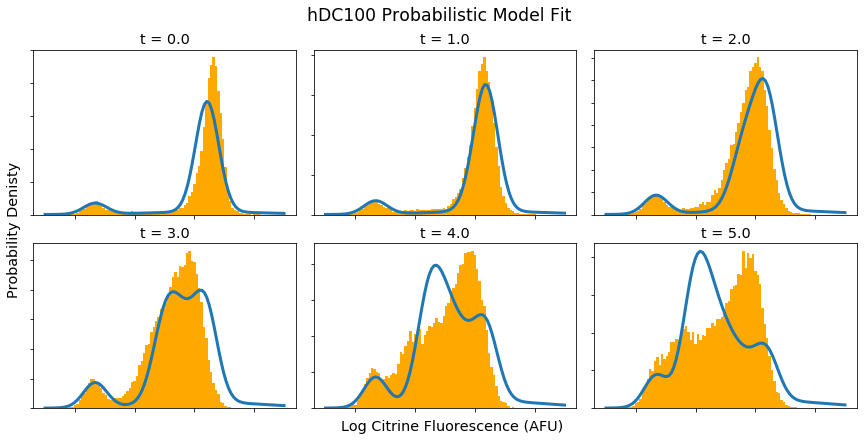

[15098.999322197531, 0.7245527586775352, 1.760444433999633, 0.2971484481665398, 1.0000000000000002, 5.248214262122635, 0.17948834526734547, 0.10000000000000002, 357.1637875053699, 2.197847940990429]


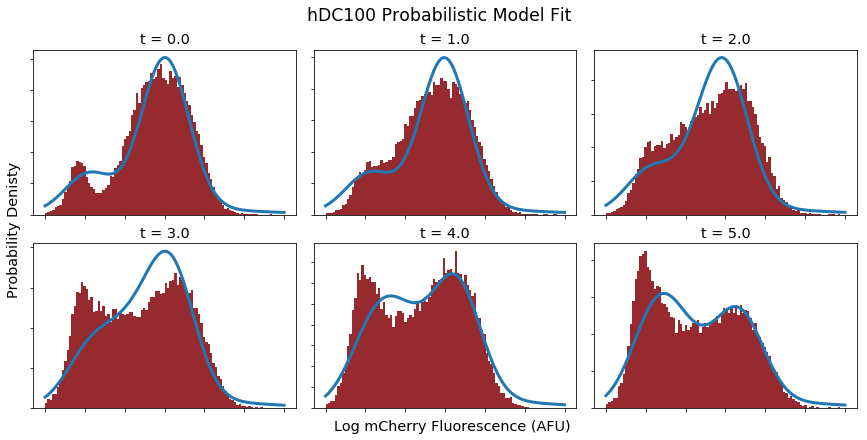

5783.773863554001


In [48]:
start = time.time()

cloneNames = ['hDC100']

optProbModel(cloneNames,i_C,b_C,i_m,b_m,xlim_C=(1.5,5.5),xlim_m=(2,5),saveAs='CHO_HDC_100dox_fit')

end = time.time()
print(end-start)

In [24]:
# setting inital guesses and bounds for Citrine
alpha = 45000  
beta = 0.8        
sigma = 0.15           
mu = 4/24      
P_b = 0.05
P_aa = 0.25
F_b = 560     

i_C = [alpha,beta,sigma,mu,P_b,P_aa,F_b]

b_C = ([10000,  0.5, 0.1, 0.001, 0,   0.1,  100],\
       [1000000, 2.0, 0.4, 3,   0.25, 0.5, 1000])

# setting inital guesses and bounds for mCherry
alpha = 25000      
gamma = 3  
sigma = 0.30   
k = 5          
mu = 2.5       
P_b = 0.40     
F_b = 630      

i_m = [alpha,gamma,sigma,k,mu,P_b,F_b]

b_m = ([5000,   1,  0.1, 1,  0, 0,    100],\
       [100000, 15, 0.4, 15, 5, 0.60, 1000])

[63219.25112241705, 0.877172341368187, 1, 0.17388628785783433, 1, 1.042160128421116, 0.06297600831772052, 0.17797065063503742, 183.43505592461597, 0]


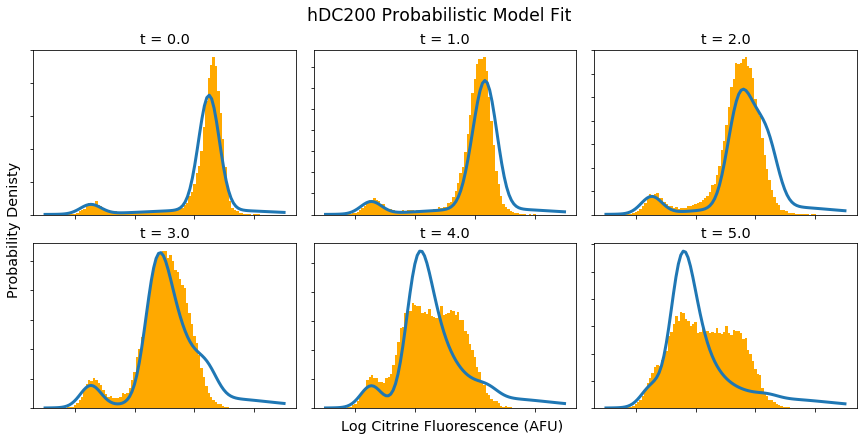

[18527.542875488474, 0.877172341368187, 1.7888000630219687, 0.2937830654520077, 1.0000000000000002, 3.383727789983487, 0.16216060515037814, 0.17797065063503742, 312.56095561584186, 1.042160128421116]


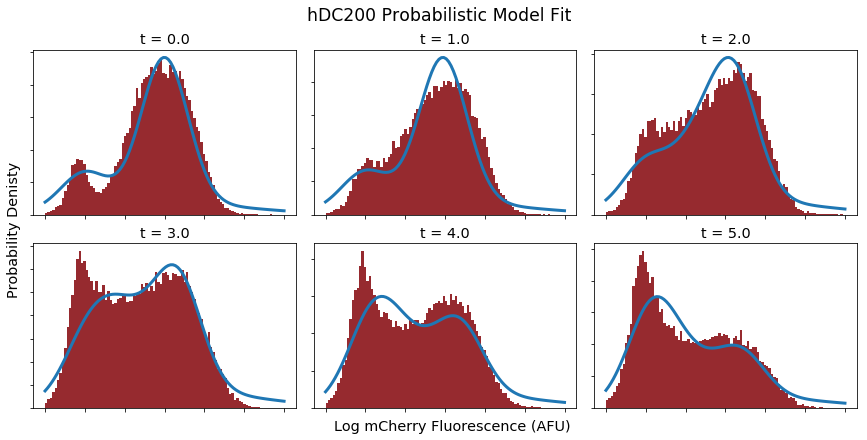

4013.0283510684967


In [25]:
start = time.time()

cloneNames = ['hDC200']

optProbModel(cloneNames,i_C,b_C,i_m,b_m,xlim_C=(1.5,5.5),xlim_m=(2,5),saveAs='CHO_HDC_200dox_fit')

end = time.time()
print(end-start)

In [26]:
# setting inital guesses and bounds for Citrine
alpha = 45000  
beta = 0.8        
sigma = 0.15           
mu = 4/24      
P_b = 0.05
P_aa = 0.25
F_b = 560     

i_C = [alpha,beta,sigma,mu,P_b,P_aa,F_b]

b_C = ([10000,  0.5, 0.1, 0.001, 0,   0.1,  100],\
       [1000000, 2.0, 0.4, 3,   0.25, 0.5, 1000])

# setting inital guesses and bounds for mCherry
alpha = 25000      
gamma = 3  
sigma = 0.30   
k = 5          
mu = 2.5       
P_b = 0.40     
F_b = 630      

i_m = [alpha,gamma,sigma,k,mu,P_b,F_b]

b_m = ([5000,   1,  0.1, 1,  0, 0,    100],\
       [100000, 15, 0.4, 15, 5, 0.60, 1000])

[77657.28633260215, 0.9737735955916231, 1, 0.16605873104492022, 1, 0.26946498045483896, 0.06777516870524716, 0.12192866034525285, 184.96201418277192, 0]


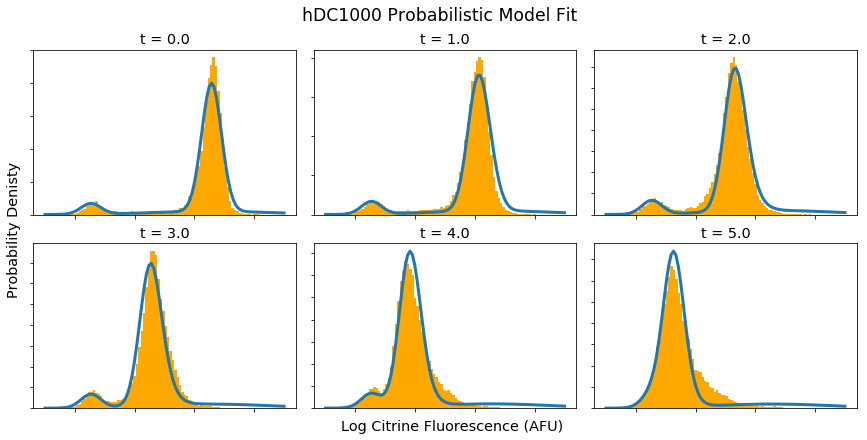

[20431.53985066679, 0.9737735955916231, 1.8597446526162682, 0.26962421165903105, 1.0000000000000002, 1.8927883606567883, 0.16096177308247772, 0.12192866034525285, 296.38975945658734, 0.26946498045483896]


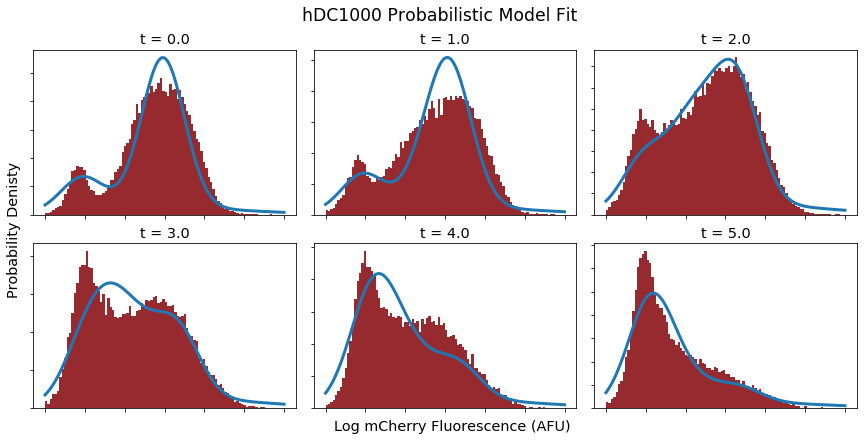

5444.7882289886475


In [27]:
start = time.time()

cloneNames = ['hDC1000']

optProbModel(cloneNames,i_C,b_C,i_m,b_m,xlim_C=(1.5,5.5),xlim_m=(2,5),saveAs='CHO_HDC_1000dox_fit')

end = time.time()
print(end-start)

### CHO HDAC4 Ins (MC) DH low dox

In [28]:
# setting inital guesses and bounds for Citrine
alpha = 45000  
beta = 0.8        
sigma = 0.15           
mu = 4/24      
P_b = 0.05
P_aa = 0.25
F_b = 560     

i_C = [alpha,beta,sigma,mu,P_b,P_aa,F_b]

b_C = ([10000,  0.5, 0.1, 0.001, 0,   0.1,  100],\
       [1000000, 2.0, 0.4, 3,   0.25, 0.5, 1000])

# setting inital guesses and bounds for mCherry
alpha = 25000      
gamma = 3  
sigma = 0.30   
k = 5          
mu = 2.5       
P_b = 0.40     
F_b = 630      

i_m = [alpha,gamma,sigma,k,mu,P_b,F_b]

b_m = ([5000,   1,  0.1, 1,  0, 0,    100],\
       [100000, 15, 0.4, 15, 5, 0.60, 1000])

[43955.65708456878, 0.5511535711639824, 1, 0.18246500953811204, 1, 1.719016231137148, 0.07831843522503162, 0.10000000000000002, 232.25213233951493, 0]


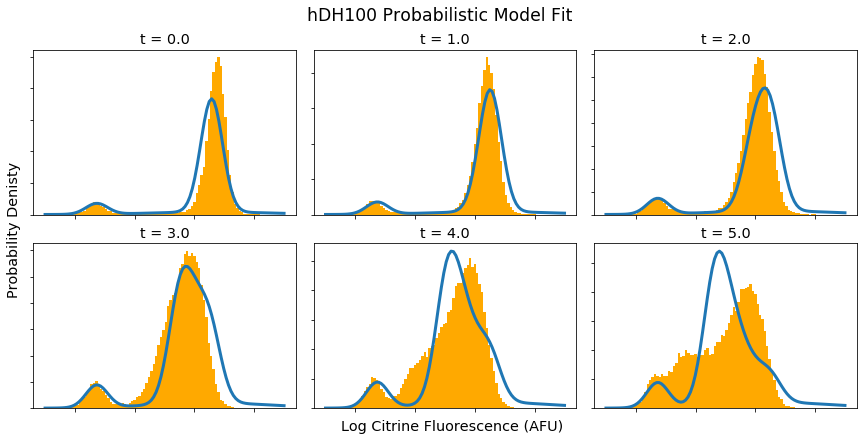

[24885.340747695216, 0.5511535711639824, 1.0000000000000002, 0.28535191908642127, 1.5685442896449537, 4.99999999999992, 0.2461138108704535, 0.10000000000000002, 414.32715336337606, 1.719016231137148]


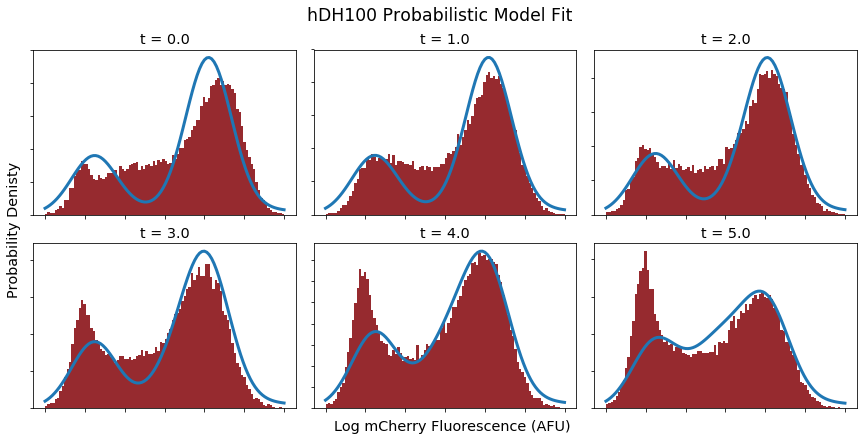

3561.9389338493347


In [29]:
start = time.time()

cloneNames = ['hDH100']

optProbModel(cloneNames,i_C,b_C,i_m,b_m,xlim_C=(1.5,5.5),xlim_m=(2,5),saveAs='CHO_HDH_100dox_fit')

end = time.time()
print(end-start)

In [49]:
# setting inital guesses and bounds for Citrine
alpha = 45000  
beta = 0.8        
sigma = 0.15           
mu = 4/24      
P_b = 0.05
P_aa = 0.25
F_b = 560     

i_C = [alpha,beta,sigma,mu,P_b,P_aa,F_b]

b_C = ([10000,  0.5, 0.1, 0.001, 0,   0.1,  100],\
       [1000000, 2.0, 0.4, 3,   0.25, 0.5, 1000])

# setting inital guesses and bounds for mCherry (Changed  mch silencing time upper bound)
alpha = 25000      
gamma = 3  
sigma = 0.30   
k = 5          
mu = 2.5       
P_b = 0.40     
F_b = 630      

i_m = [alpha,gamma,sigma,k,mu,P_b,F_b]

b_m = ([5000,   1,  0.1, 1,  0, 0,    100],\
       [100000, 15, 0.4, 15, 8, 0.60, 1000])

[43955.65708456878, 0.5511535711639824, 1, 0.18246500953811204, 1, 1.719016231137148, 0.07831843522503162, 0.10000000000000002, 232.25213233951493, 0]


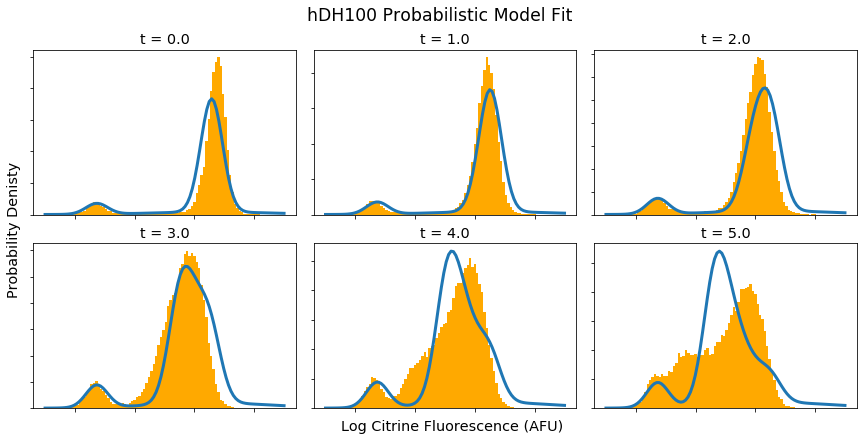

[24766.031693528614, 0.5511535711639824, 1.0000000000000002, 0.28442491395889336, 1.1342451707263044, 6.323712756241357, 0.24416272881672393, 0.10000000000000002, 411.9035764525622, 1.719016231137148]


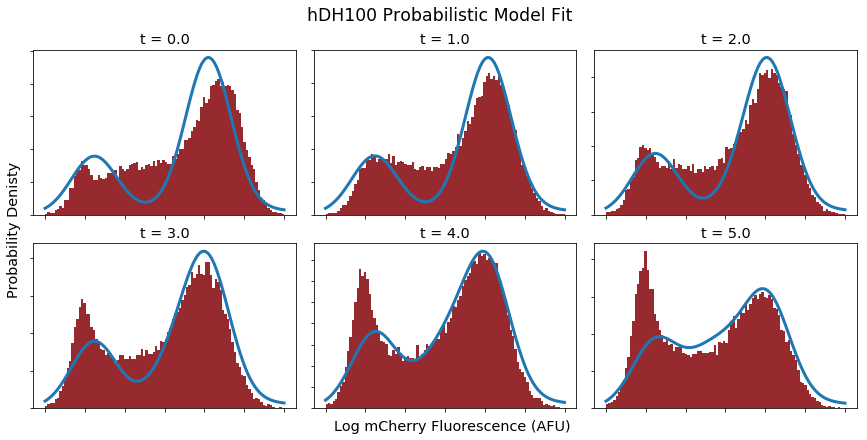

5074.011683702469


In [50]:
start = time.time()

cloneNames = ['hDH100']

optProbModel(cloneNames,i_C,b_C,i_m,b_m,xlim_C=(1.5,5.5),xlim_m=(2,5),saveAs='CHO_HDH_100dox_fit')

end = time.time()
print(end-start)

In [30]:
# setting inital guesses and bounds for Citrine
alpha = 45000  
beta = 0.8        
sigma = 0.15           
mu = 4/24      
P_b = 0.05
P_aa = 0.25
F_b = 560     

i_C = [alpha,beta,sigma,mu,P_b,P_aa,F_b]

b_C = ([10000,  0.5, 0.1, 0.001, 0,   0.1,  100],\
       [1000000, 2.0, 0.4, 3,   0.25, 0.5, 1000])

# setting inital guesses and bounds for mCherry
alpha = 25000      
gamma = 3  
sigma = 0.30   
k = 5          
mu = 2.5       
P_b = 0.40     
F_b = 630      

i_m = [alpha,gamma,sigma,k,mu,P_b,F_b]

b_m = ([5000,   1,  0.1, 1,  0, 0,    100],\
       [100000, 15, 0.4, 15, 5, 0.60, 1000])

[64001.56391488296, 0.7707282871409654, 1, 0.17756929250001846, 1, 0.8816058671649091, 0.065846722853921, 0.12677880422510032, 201.3959039746568, 0]


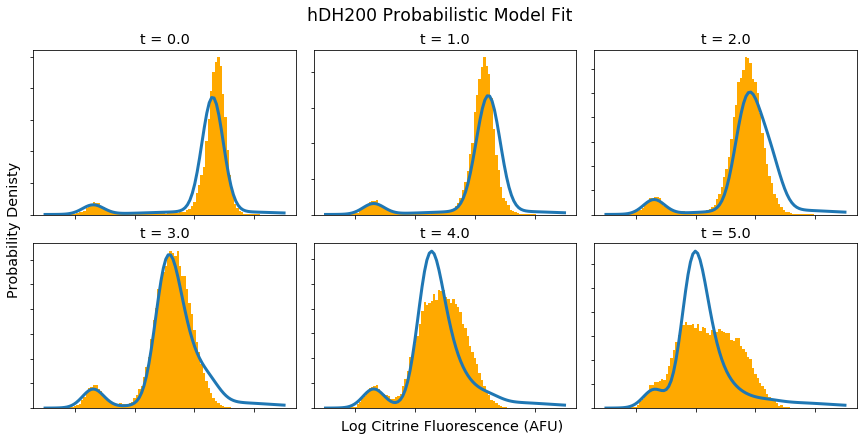

[32721.222819741124, 0.7707282871409654, 1.0000000000000002, 0.2893065454829482, 2.4275575315318627, 3.9865124479255973, 0.2504992063839219, 0.12677880422510032, 393.555161590779, 0.8816058671649091]


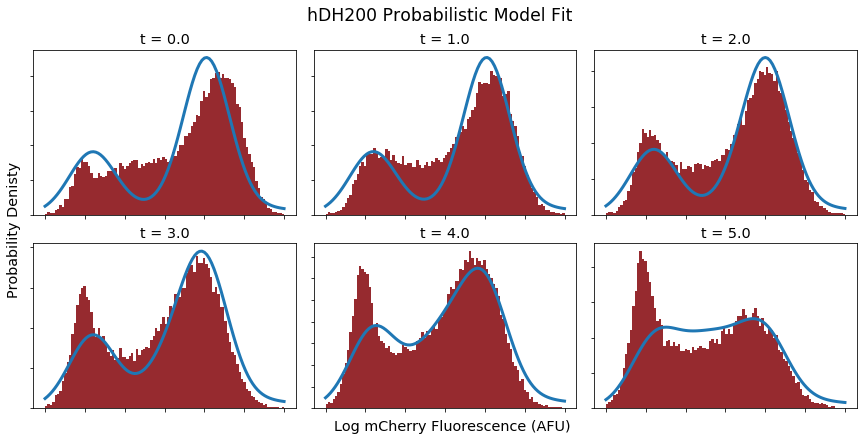

2732.0263073444366


In [31]:
start = time.time()

cloneNames = ['hDH200']

optProbModel(cloneNames,i_C,b_C,i_m,b_m,xlim_C=(1.5,5.5),xlim_m=(2,5),saveAs='CHO_HDH_200dox_fit')

end = time.time()
print(end-start)

In [32]:
# setting inital guesses and bounds for Citrine
alpha = 45000  
beta = 0.8        
sigma = 0.15           
mu = 4/24      
P_b = 0.05
P_aa = 0.25
F_b = 560     

i_C = [alpha,beta,sigma,mu,P_b,P_aa,F_b]

b_C = ([10000,  0.5, 0.1, 0.001, 0,   0.1,  100],\
       [1000000, 2.0, 0.4, 3,   0.25, 0.5, 1000])

# setting inital guesses and bounds for mCherry
alpha = 25000      
gamma = 3  
sigma = 0.30   
k = 5          
mu = 2.5       
P_b = 0.40     
F_b = 630      

i_m = [alpha,gamma,sigma,k,mu,P_b,F_b]

b_m = ([5000,   1,  0.1, 1,  0, 0,    100],\
       [100000, 15, 0.4, 15, 5, 0.60, 1000])

C:\Users\Sarah\.conda\envs\cytoflow\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


[86271.23402072144, 0.9045883211029613, 1, 0.16894083600706225, 1, 0.0010000000000028886, 0.06514912147229182, 0.10000000000555392, 202.1736504102187, 0]


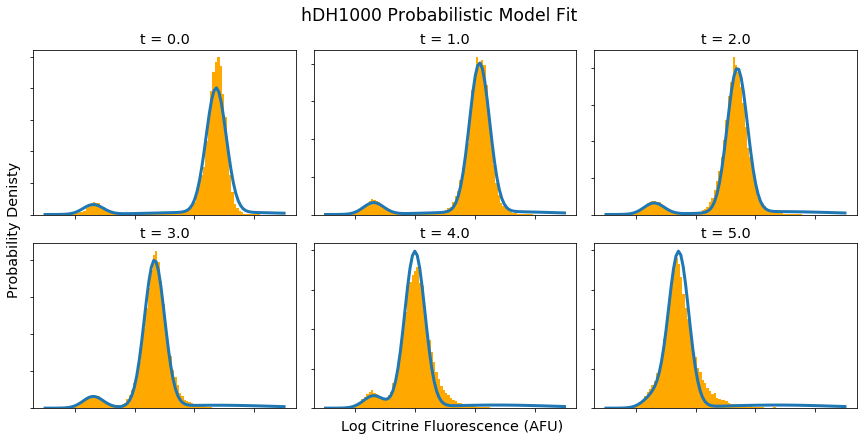

[36889.46850178369, 0.9045883211029613, 1.0000000000000002, 0.27788758151579995, 1.9326090466682784, 2.042149584689353, 0.2621146030277479, 0.10000000000555392, 334.323412540409, 0.0010000000000028886]


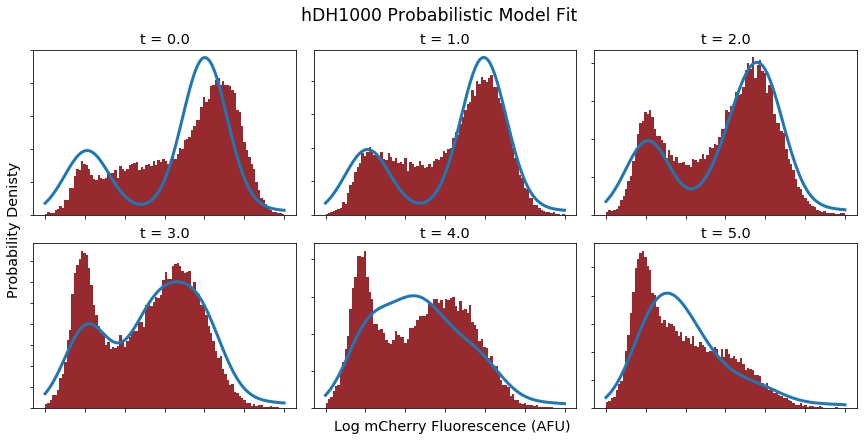

3649.7579848766327


In [33]:
start = time.time()

cloneNames = ['hDH1000']

optProbModel(cloneNames,i_C,b_C,i_m,b_m,xlim_C=(1.5,5.5),xlim_m=(2,5),saveAs='CHO_HDH_1000dox_fit')

end = time.time()
print(end-start)